In [1]:
# 云端数据
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch-tabnet scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

In [4]:
# 读取数据
data = pd.read_csv('/content/drive/MyDrive/data/MetaverseFinancialTX/metaverse.csv')
data.shape

(78600, 14)

In [5]:
from sklearn.preprocessing import LabelEncoder

# 初始化LabelEncoder
le = LabelEncoder()

# 将数据集划分为特征和目标变量
X = data.drop(['timestamp', 'sending_address', 'receiving_address', 'risk_score','anomaly'], axis=1)
y = data['anomaly']

# 将目标变量编码为数字
label_map = {'low_risk': 0, 'moderate_risk': 1, 'high_risk': 2}
y = y.map(label_map)

# 对类别特征进行数字编码
for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype.name == 'category':
        X[col] = le.fit_transform(X[col])

# 将所有特征转换为数字类型
X = X.astype(float)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 获取类别特征的索引
cat_idxs = [i for i, col in enumerate(X.columns) if X[col].dtype == 'object' or X[col].dtype.name == 'category']

# 获取每个类别特征的唯一值数量
cat_dims = [X[col].nunique() for col in X.columns[cat_idxs]]


In [6]:
from sklearn.preprocessing import LabelEncoder
# 初始化LabelEncoder
le = LabelEncoder()

# 将数据集划分为特征和目标变量
X = data.drop(['timestamp', 'sending_address', 'receiving_address', 'risk_score','anomaly'], axis=1)
y = data['anomaly']

# 将目标变量编码为数字
label_map = {'low_risk': 0, 'moderate_risk': 1, 'high_risk': 2}
y = y.map(label_map)

# 对类别特征进行数字编码
for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype.name == 'category':
        X[col] = le.fit_transform(X[col])

# 将所有特征转换为数字类型
X = X.astype(float)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 获取类别特征的索引
cat_idxs = [i for i, col in enumerate(X.columns) if X[col].dtype == 'object' or X[col].dtype.name == 'category']

# 获取每个类别特征的唯一值数量
cat_dims = [X[col].nunique() for col in X.columns[cat_idxs]]

from pytorch_tabnet.callbacks import EarlyStopping
# 创建 EarlyStopping 回调函数
early_stopping = EarlyStopping(
    early_stopping_metric='val_accuracy', # 使用验证集上的准确率作为早停的评估指标
    is_maximize=True, # 准确率是最大化指标
    patience=5 # 如果连续 5 个 epoch 没有改善,就停止训练
)

# 创建 TabNetClassifier 模型并进行训练
model = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5, gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs, cat_dims=cat_dims, cat_emb_dim=1,
    optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=1e-3),
    scheduler_params={"step_size": 50, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax', seed=42, verbose=1
)

# 训练模型,并传入 EarlyStopping 回调函数
model.fit(
    X_train.values, y_train.values,
    eval_set=[(X_test.values, y_test.values)], # 指定验证集
    max_epochs=100, # 最大训练轮数
    patience=5, # 如果连续 5 个 epoch 没有改善,就停止训练
    batch_size=1024, virtual_batch_size=128,
    callbacks=[early_stopping] # 传入 EarlyStopping 回调函数
)

# 在测试集上进行预测并评估模型性能
preds = model.predict(X_test.values)

# 将预测结果转换为对应的标签
preds_labels = [list(label_map.keys())[list(label_map.values()).index(pred)] for pred in preds]
y_test_labels = [list(label_map.keys())[list(label_map.values()).index(y)] for y in y_test.values]

print(f"Accuracy: {accuracy_score(y_test_labels, preds_labels):.4f}")
print(classification_report(y_test_labels, preds_labels))

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.37957 | val_0_accuracy: 0.62977 |  0:00:05s
epoch 1  | loss: 0.10535 | val_0_accuracy: 0.80261 |  0:00:10s
epoch 2  | loss: 0.05491 | val_0_accuracy: 0.9208  |  0:00:14s
epoch 3  | loss: 0.03676 | val_0_accuracy: 0.97742 |  0:00:19s
epoch 4  | loss: 0.02982 | val_0_accuracy: 0.9876  |  0:00:23s
epoch 5  | loss: 0.02791 | val_0_accuracy: 0.99377 |  0:00:27s
epoch 6  | loss: 0.02386 | val_0_accuracy: 0.99574 |  0:00:31s
epoch 7  | loss: 0.0213  | val_0_accuracy: 0.9972  |  0:00:35s
epoch 8  | loss: 0.01957 | val_0_accuracy: 0.99733 |  0:00:39s
epoch 9  | loss: 0.01734 | val_0_accuracy: 0.99739 |  0:00:43s
epoch 10 | loss: 0.0162  | val_0_accuracy: 0.99707 |  0:00:48s
epoch 11 | loss: 0.01519 | val_0_accuracy: 0.99707 |  0:00:52s
epoch 12 | loss: 0.01412 | val_0_accuracy: 0.99828 |  0:00:56s
epoch 13 | loss: 0.01422 | val_0_accuracy: 0.99752 |  0:01:00s
epoch 14 | loss: 0.01431 | val_0_accuracy: 0.99784 |  0:01:05s
epoch 15 | loss: 0.01248 | val_0_accuracy: 0.99682 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy: 0.9983
               precision    recall  f1-score   support

    high_risk       1.00      1.00      1.00      1251
     low_risk       1.00      1.00      1.00     12848
moderate_risk       0.99      1.00      0.99      1621

     accuracy                           1.00     15720
    macro avg       1.00      1.00      1.00     15720
 weighted avg       1.00      1.00      1.00     15720



In [7]:
from sklearn.metrics import classification_report, accuracy_score

# 将预测结果和真实标签转换为对应的字符串标签
def to_labels(preds, label_map):
    return [list(label_map.keys())[list(label_map.values()).index(pred)] for pred in preds]

# 在训练集上进行预测并评估性能
train_preds = model.predict(X_train.values)
train_preds_labels = to_labels(train_preds, label_map)
y_train_labels = to_labels(y_train.values, label_map)

print("Training Performance:")
print(f"Accuracy: {accuracy_score(y_train_labels, train_preds_labels):.4f}")
print(classification_report(y_train_labels, train_preds_labels))

# 在测试集上进行预测并评估性能
test_preds = model.predict(X_test.values)
test_preds_labels = to_labels(test_preds, label_map)
y_test_labels = to_labels(y_test.values, label_map)

print("Testing Performance:")
print(f"Accuracy: {accuracy_score(y_test_labels, test_preds_labels):.4f}")
print(classification_report(y_test_labels, test_preds_labels))

Training Performance:
Accuracy: 0.9984
               precision    recall  f1-score   support

    high_risk       1.00      1.00      1.00      5244
     low_risk       1.00      1.00      1.00     50646
moderate_risk       0.99      1.00      0.99      6990

     accuracy                           1.00     62880
    macro avg       1.00      1.00      1.00     62880
 weighted avg       1.00      1.00      1.00     62880

Testing Performance:
Accuracy: 0.9983
               precision    recall  f1-score   support

    high_risk       1.00      1.00      1.00      1251
     low_risk       1.00      1.00      1.00     12848
moderate_risk       0.99      1.00      0.99      1621

     accuracy                           1.00     15720
    macro avg       1.00      1.00      1.00     15720
 weighted avg       1.00      1.00      1.00     15720



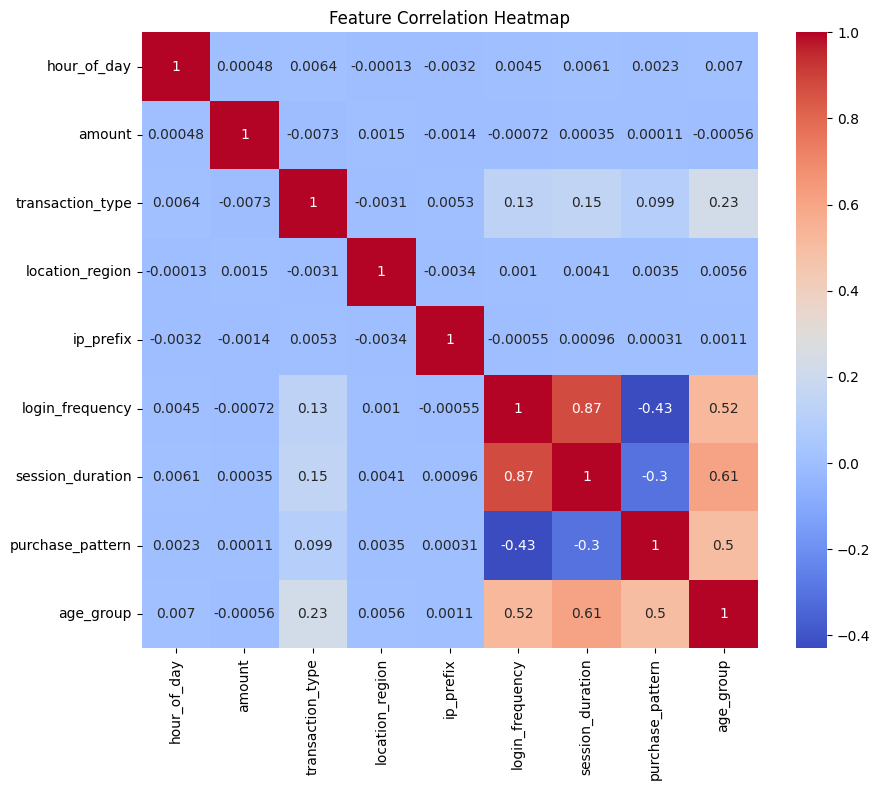

In [8]:
# 特征之间的相关性热力图:
import seaborn as sns
import matplotlib.pyplot as plt

# 计算特征之间的相关性
corr = X.corr()

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title('Feature Correlation Heatmap')
plt.show()

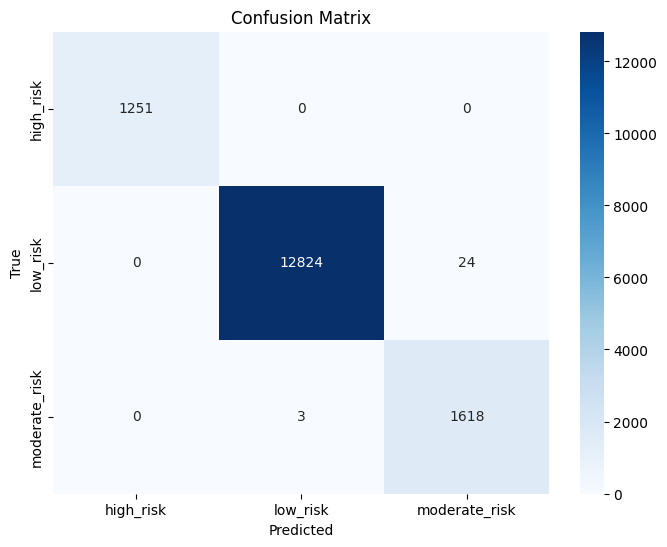

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 将预测结果和真实标签转换为对应的字符串标签
def to_labels(preds, label_map):
    return [list(label_map.keys())[list(label_map.values()).index(pred)] for pred in preds]

# 计算混淆矩阵
cm = confusion_matrix(y_test_labels, test_preds_labels)

# 获取字符串标签
labels = sorted(label_map.keys())

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

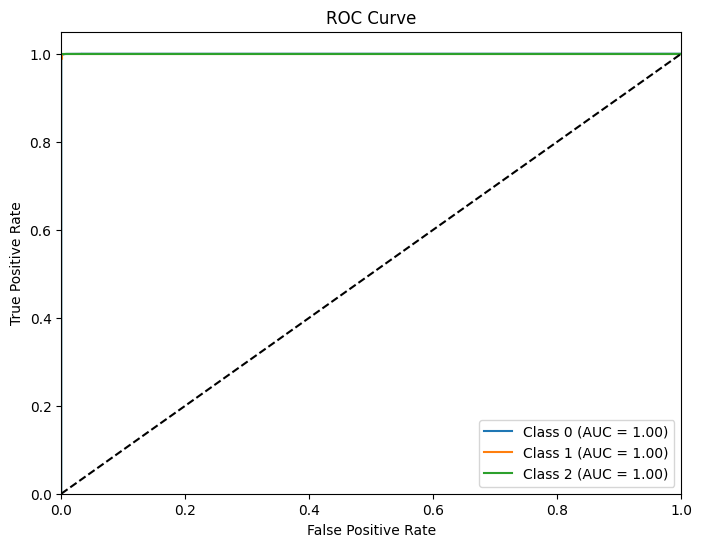

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# 将标签二值化
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_pred_prob = model.predict_proba(X_test.values)

# 计算每个类别的ROC AUC
roc_auc = roc_auc_score(y_test_bin, y_pred_prob, multi_class='ovr')

# 绘制ROC曲线
fpr = dict()
tpr = dict()
for i in range(len(np.unique(y))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])

plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


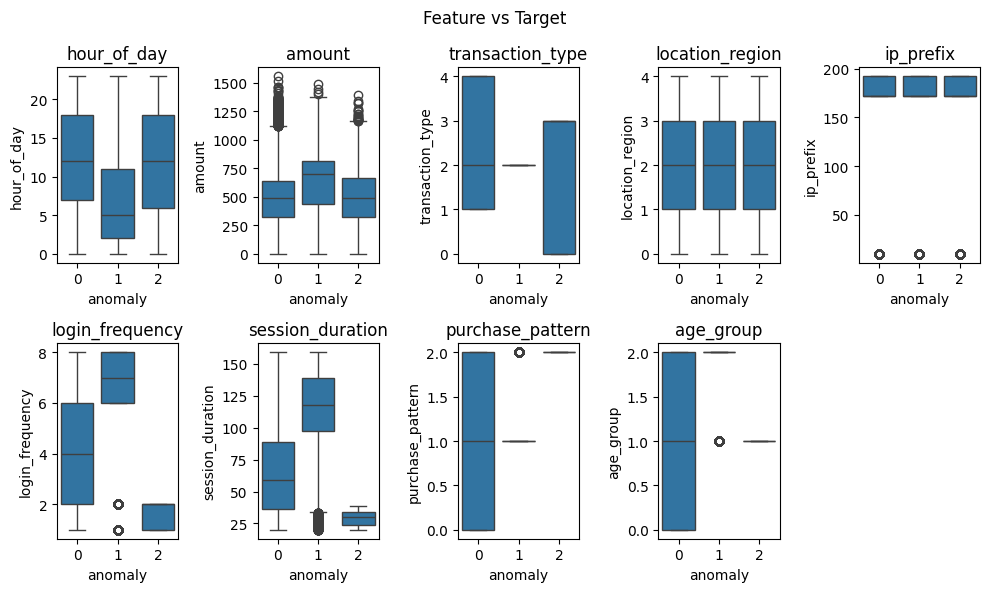

In [11]:
# 特征与目标变量的关系(箱线图):
plt.figure(figsize=(10, 6))
for i, col in enumerate(X.columns):
    plt.subplot(2, 5, i+1)
    sns.boxplot(x=y, y=X[col])
    plt.title(col)
plt.suptitle('Feature vs Target')
plt.tight_layout()
plt.show()